In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [5]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='24h',
    price_calculation='close',
)

In [6]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [7]:
price_data = add_features(price_data.copy())

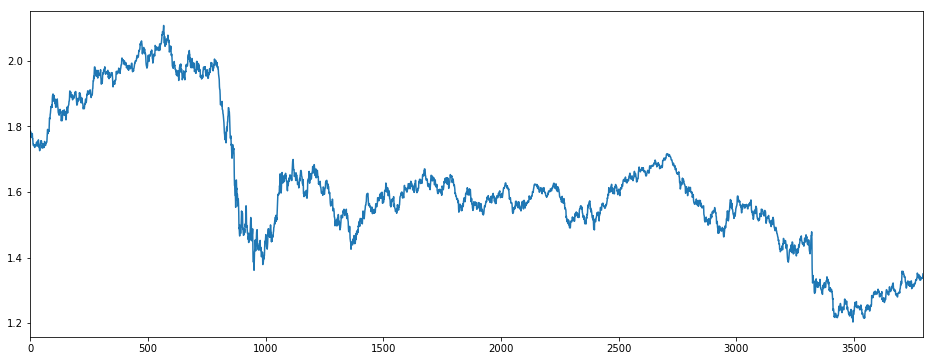

In [8]:
price_data['price'].plot(figsize=(16,6))

In [9]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2529, test size 1265


In [10]:
episode=1000
batch_size=10

In [11]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-23,1.78650,1.78870,1.77240,1.77300,1.78650,0.684025,0.012350,0.356406
1,1,2006-01-24,1.78325,1.78975,1.78055,1.78660,1.78325,0.692125,0.011561,0.401366
2,2,2006-01-25,1.78390,1.79345,1.78180,1.78325,1.78390,0.721188,0.011583,0.389347
3,3,2006-01-26,1.78130,1.78905,1.77785,1.78370,1.78130,0.646064,0.011487,0.368281
4,4,2006-01-27,1.76740,1.78795,1.76685,1.78120,1.76740,0.484047,0.013893,0.350522


In [12]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [13]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 1509 pips, median trade count: 204
....................
episode: 40/1000
median profit: 3154 pips, median trade count: 184
....................
episode: 60/1000
median profit: 3734 pips, median trade count: 190
....................
episode: 80/1000
median profit: 4663 pips, median trade count: 190
....................
episode: 100/1000
median profit: 5252 pips, median trade count: 189
....................
episode: 120/1000
median profit: 6778 pips, median trade count: 206
....................
episode: 140/1000
median profit: 7683 pips, median trade count: 219
....................
episode: 160/1000
median profit: 8031 pips, median trade count: 228
....................
episode: 180/1000
median profit: 8058 pips, median trade count: 245
....................
episode: 200/1000
median profit: 8293 pips, median trade count: 257
....................
episode: 220/1000
median profit: 8584 pips, median trade count: 265
....................
ep

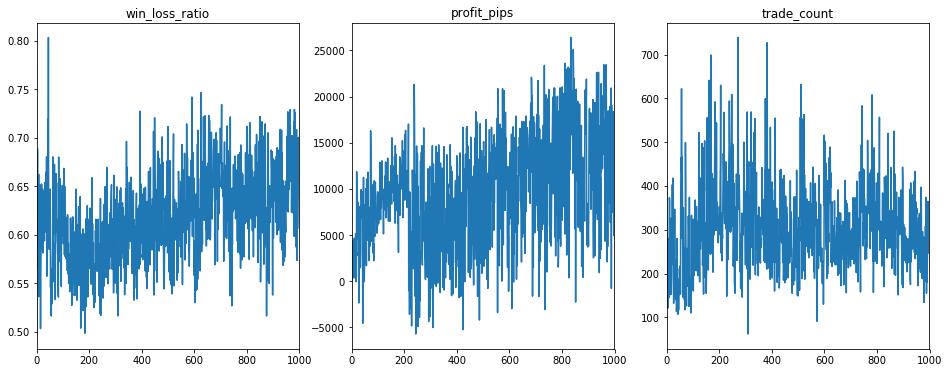

In [14]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [15]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['24h-GBP_USD.pkl']

## Test

In [16]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [17]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [18]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [19]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 1339.8749999999704 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135f37b10>]],
      dtype=object)

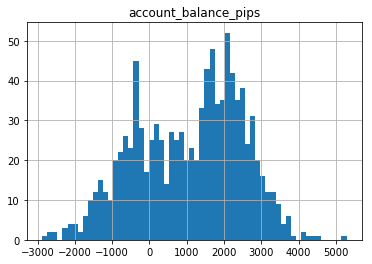

In [20]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [21]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [22]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [23]:
env._stats()

{'trade_count': 103,
 'win_loss_ratio': 0.7281553398058253,
 'account_balance': 0.27902499999999386,
 'unrealised_pl': 0.009424999999999795}

In [24]:
position_data = env.price_data.copy()

In [25]:
position_data['position'] = position_data['position'] - 1

In [26]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

105 positions to plot...


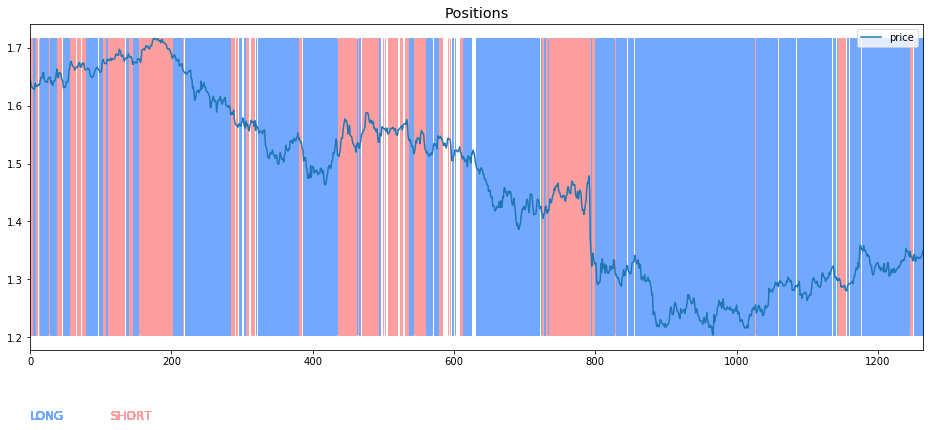

In [27]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [28]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 73.33%
Ratio of long to short positions: 1.17
Median profit: 0.0
Total profit: 0.29624999999999857
Median position length: 4.0
Number of trades: 105


In [29]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-12-10,1.64574,2013-12-11,1.63755,1,NaN,NaN,False,NaN
1,2013-12-11,1.63755,2013-12-13,1.63008,2,-1.0,0.00747,True,0.00747
2,2013-12-15,1.62990,2013-12-19,1.63654,4,1.0,0.00664,True,0.01411
3,2013-12-19,1.63654,2013-12-23,1.63498,3,-1.0,0.00156,True,0.01567
4,2013-12-24,1.63698,2013-12-25,1.63526,1,-1.0,0.00172,True,0.01739
...,...,...,...,...,...,...,...,...,...
100,2017-09-07,1.31042,2017-09-13,1.32070,5,1.0,0.01028,True,0.27401
101,2017-09-14,1.33972,2017-09-17,1.35762,2,1.0,0.01790,True,0.29191
102,2017-09-18,1.35148,2017-12-06,1.33912,68,1.0,-0.01236,False,0.27955
103,2017-12-06,1.33912,2017-12-12,1.33192,5,-1.0,0.00720,True,0.28675


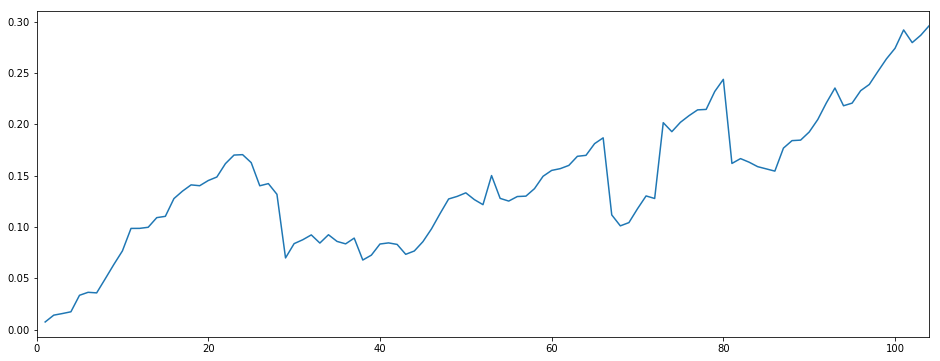

In [30]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.1163800000000006


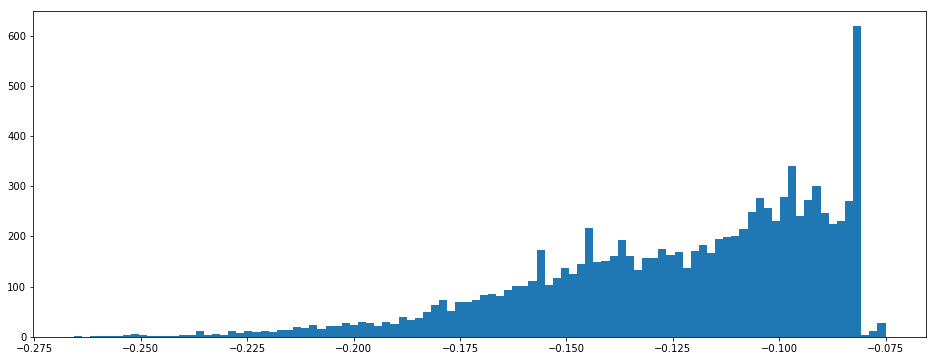

In [31]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);